# Управление рисками 2024. Домашнее задание №1.

*Дата выдачи: 06.03.2024*

*Дедлайн: 20.03.2024, 23:59*

## Часть 1. График линейности признака по WoE.

В этой части домашки мы познакомимся с одним из основных инструментов для анализа переменных в модели логистической регрессии - графиком линейности. 

Кратко идею этого графика можно сформулировать так:
 - модель *линейной* регрессии корректно применять, если значение $y$ *линейно* связано со значением $x$. Иначе линрег не подходит для данной задачи и даст неверные результаты.
 - аналогичную проверку хочется сделать и для *логистической* регрессии. Но как проверить линейность, если таргет принимает всего два значения?
 - для этого необходимо преобразовать таргет: разбить признак на бакеты и в каждом бакете посчитать WoE
 - **линейность признака по WoE для логрега – аналог линейной связи признака и таргета для линрега**

Ниже пример признака с неплохой линейностью:

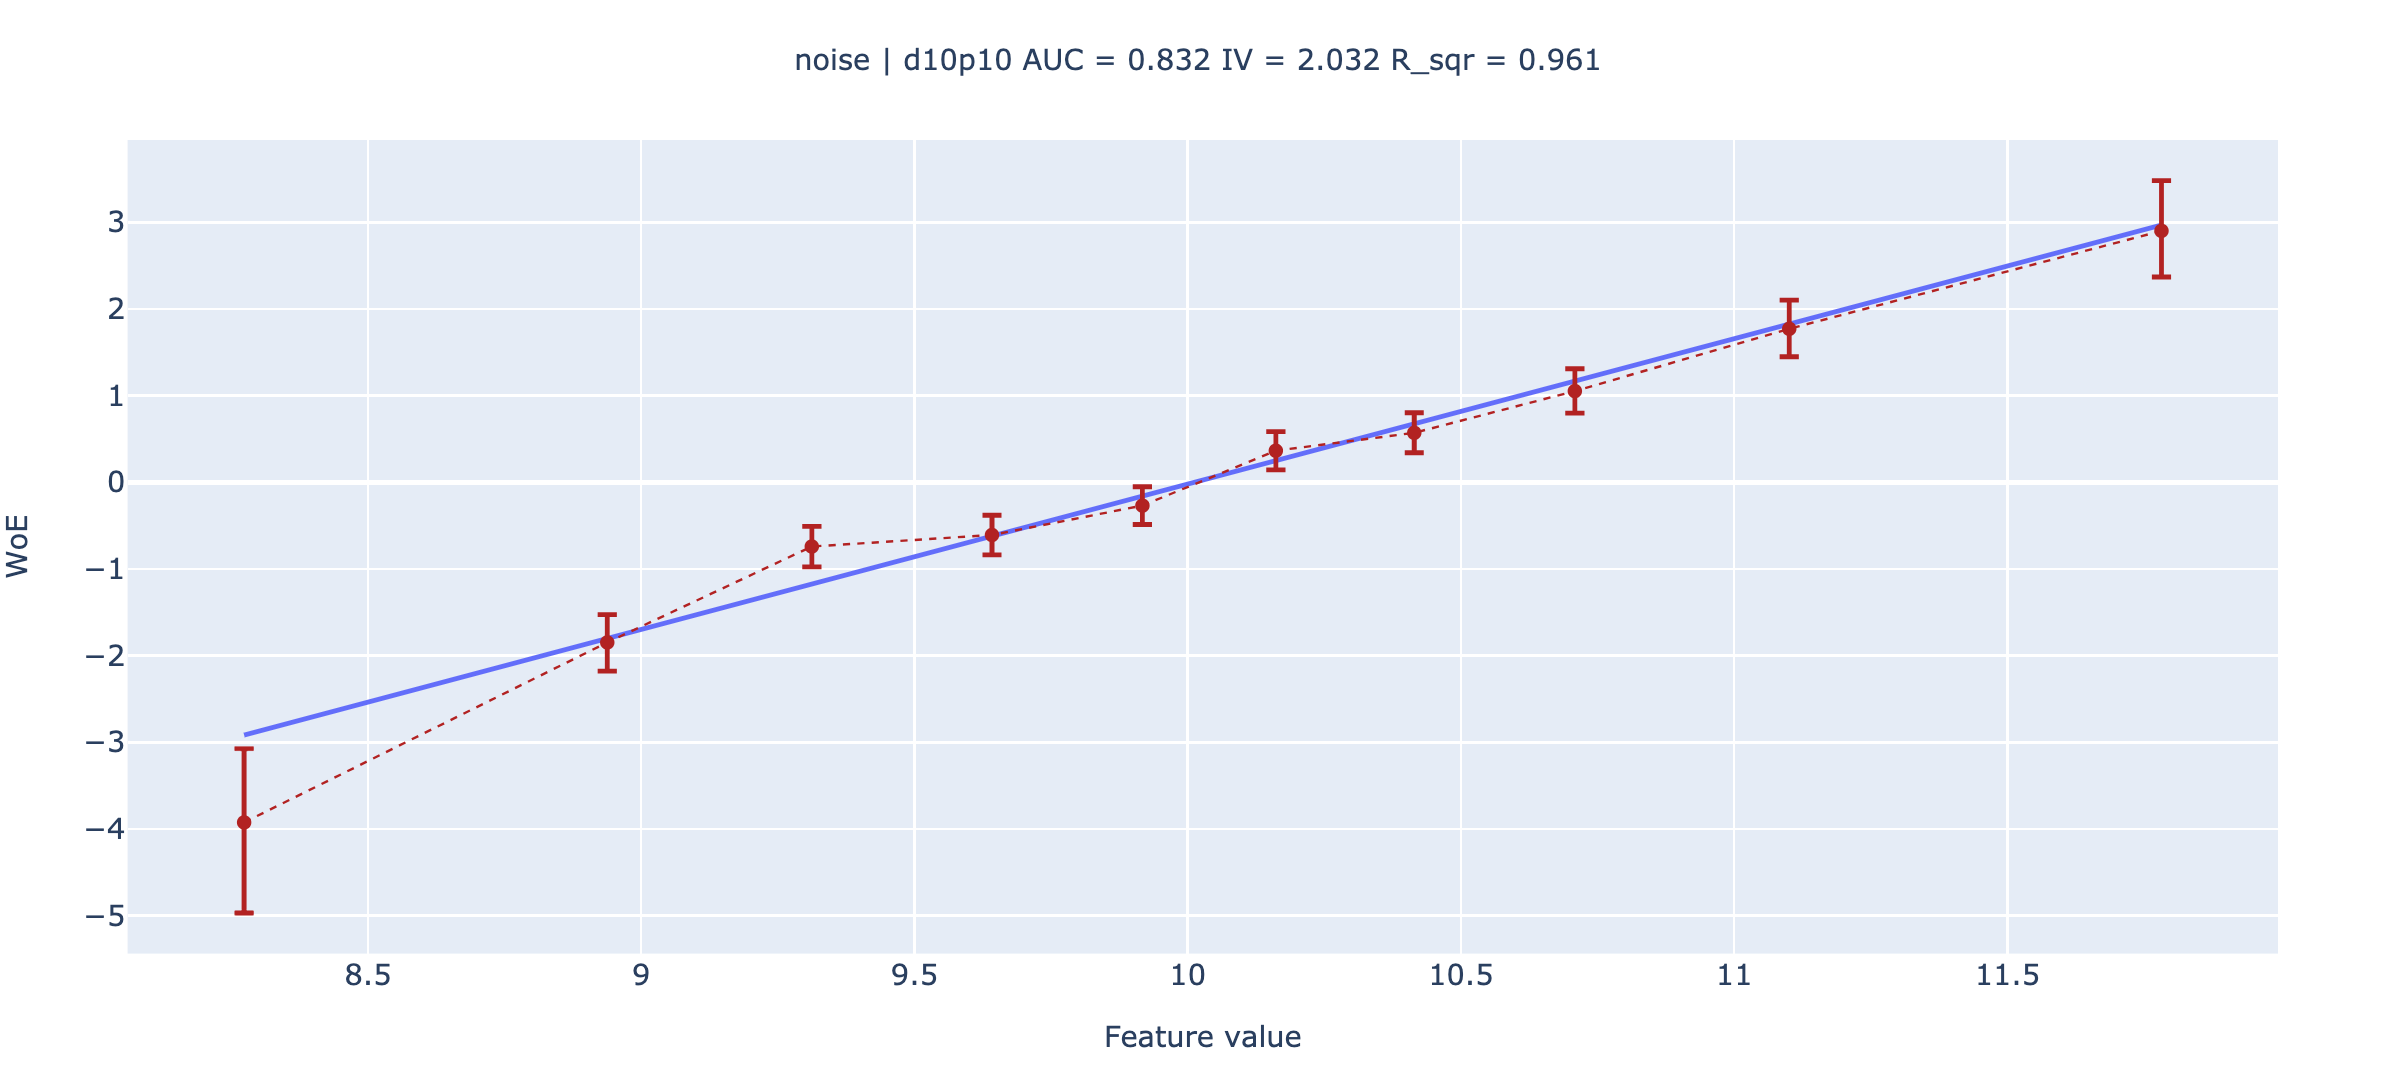

Нам нужно обратить внимание на 3 вещи:

**1. Фиолетовые точки с доверительными интервалами.**

Это WoE для каждого отдельного бакета. В идеале нам бы хотелось, чтобы **через эти точки можно было провести прямую линию** с небольшой погрешностью. Это и означает линейную взаимосвязь с таргетом.

**2. Синяя линия**

Попытка провести прямую линию через точки. Строится с помощью логистической регрессии на одной переменной. Затем предсказания переводятся в пространство WoE, отчего и получается прямая линия.

**3. Метрики в заголовке графика**

Метрики для признака:
 - roc auc, IV измеряют разделяющую способность переменной
 - $R^2$ измеряет *линейность взаимосвязи*. Признак считается линейным, если $R^2 \geq 0.95$

Далее напишем woe-line руками, чтобы в деталях разобраться, как он строится.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
from typing import Union, Tuple

### Шаг 0: разбиение на бакеты

In [2]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на 
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

In [3]:
sample_size = 20
values = np.random.normal(50, 30, sample_size)
target = np.random.randint(0, 2, sample_size)
calc_buckets(values, 4), values

(array([1, 1, 3, 0, 0, 1, 3, 2, 3, 3, 1, 2, 2, 0, 0, 2, 0, 2, 1, 3],
       dtype=int16),
 array([55.80656082, 49.33598295, 76.86267478, -8.78161208, 31.45575049,
        35.97877272, 65.0784482 , 58.87896697, 79.74909489, 79.60751129,
        32.2302621 , 60.58949012, 60.98193093, 15.50281895, -8.34308166,
        55.92487359,  5.49629201, 56.0145744 , 43.09139739, 64.14100142]))

### Шаг 1: расчет WoE по бакетам

Пусть $x_i \in \{ 0, 1\}^n$

$x_i$ - это вектор, состоящий из значений таргета *в одном бакете* $i$. 

Для бакета можно посчитать количество единиц $B_i$ (bads, выпавшие в дефолт) и количество нулей $G_i$ (goods).

$$
B_i = \sum_{j \in x_i} \mathbb{I} \{ j = 1\}\quad G_i = \sum_{j \in x_i} \mathbb{I} \{ j = 0\}
$$

Также число бэдов и гудов можно посчитать и **для всей выборки**: 

$$
% X = x_1 \cup x_2 \ldots \cup x_n
X = \{x_1,\; x_2\; \ldots\; x_n\}
$$

$$
B = \sum_{j \in X} \mathbb{I} \{ j = 1\}\quad G = \sum_{j \in X} \mathbb{I} \{ j = 0\}
$$

Тогда WoE можно посчитать как

$$
\text{WoE}_i(x) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big ) 
$$

**Задание**

Убедиться, что

$$
\text{WoE}_i(x) = \text{logit}(b_i) - \text{logit}(b)\quad  (1)
$$

где 

$$
b = \frac{B}{B + G}\quad \text{logit}(p) = \ln \Big (  \frac{p}{1 - p} \Big )
$$

В дальнейшем будем считать WoE по формуле $(1)$

In [4]:
from scipy.special import logit

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    epsilon = 0.001
    badrate = np.clip(badrate, epsilon, 1 - epsilon)
    woe = logit(badrate) - offset
    return woe

Здесь и далее предлагается протестироать получившиеся функции. Нужно проверить, что
 - функция не ложится с ошибкой
 - возвращает то, что ожидается

In [5]:
print(woe_transform(0, 0))
print(woe_transform(1, 0))
print(woe_transform(20, 0))

-6.906754778648554
6.906754778648553
6.906754778648553


Ниже представлен шаблон функции, которая будет считать доверительный интервал к нашим вычислениям. Можно воспользоваться любым способом, который вам больше нравится. Для идей можно посмотреть различные способы подсчета доверительного интервала [здесь](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval).

**P. S.**
Для того, чтобы построить доверительный интервал к $WoE$, можно сначала построить его для величины  $b_i = \frac{B_i}{B_i+G_i}$, а потом применить ```woe_transform```. В свою очередь величина $b_i$ является параметром распределения Бернулли, который мы можем оценить классическими методами (см. ссылку выше)

In [6]:
def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[pd.Series]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""
    # считаем бэдрейт и доверительный интервал для него (любым способом)
    z = 1.96

    _, indices = np.unique(buckets, return_inverse=True)
    bucket_n = np.bincount(indices)

    bucket_sum = np.bincount(indices, weights=target)
    badrate_i = bucket_sum / bucket_n

    delta_badrate = z * np.sqrt((badrate_i * (1 - badrate_i)) / bucket_n)
    badrate_lower = np.maximum(badrate_i - delta_badrate, 0)
    badrate_upper = np.minimum(badrate_i + delta_badrate, 1)

    woe = pd.Series(woe_transform(badrate_i, offset))
    woe_lower = pd.Series(woe_transform(badrate_lower, offset))
    woe_upper = pd.Series(woe_transform(badrate_upper, offset))


    return woe, woe_lower, woe_upper

In [7]:
buckets = calc_buckets(values, 5)
woe_ci(target, buckets, 0)

(0   -6.906755
 1    1.098612
 2    0.000000
 3   -1.098612
 4   -6.906755
 dtype: float64,
 0   -6.906755
 1   -0.727937
 2   -4.595120
 3   -6.906755
 4   -6.906755
 dtype: float64,
 0   -6.906755
 1    6.906755
 2    4.595120
 3    0.727937
 4   -6.906755
 dtype: float64)

### Шаг 2: расчет линейной интерполяции

In [8]:
from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""

    # строим логистическую регрессию на одном признаке
    # и считаем ее предсказания в точках – mean_feature
    values = values.reshape((-1, 1))
    mean_feature = mean_feature.reshape((-1, 1))
    model = LogisticRegression()
    model.fit(values, target)
    proba = model.predict_proba(mean_feature)[:, 1]
    line = woe_transform(proba, offset)
    return line

In [9]:
mean_feature = np.bincount(buckets, weights=values) / np.bincount(buckets)
calc_line(values, target, mean_feature, 0)

array([-0.95708117, -0.87209945, -0.8266195 , -0.80978651, -0.77508791])

### Шаг3: собираем результаты по бакетам в один словарь

In [10]:
def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""

    offset = logit(target.sum() / len(target))

    buckets_info = {
        "mean_feature" : None,
        "line"         : None,
        "woe"          : None,
        "woe_lower"    : None,
        "woe_upper"    : None
    }

    buckets_info["woe"], buckets_info["woe_lower"], buckets_info["woe_upper"] = woe_ci(target, buckets, offset)

    buckets_info["mean_feature"] = np.bincount(buckets, weights=values) / np.bincount(buckets)

    buckets_info["line"] = calc_line(values, target, buckets_info["mean_feature"], offset)

    return buckets_info

In [11]:
calc_buckets_info(values, target, buckets)

{'mean_feature': array([ 0.96860431, 35.68904568, 54.27049794, 61.14784736, 75.32443229]),
 'line': array([-0.10978331, -0.02480159,  0.02067836,  0.03751135,  0.07220995]),
 'woe': 0   -6.059457
 1    1.945910
 2    0.847298
 3   -0.251314
 4   -6.059457
 dtype: float64,
 'woe_lower': 0   -6.059457
 1    0.119361
 2   -3.747822
 3   -6.059457
 4   -6.059457
 dtype: float64,
 'woe_upper': 0   -6.059457
 1    7.754053
 2    5.442418
 3    1.575235
 4   -6.059457
 dtype: float64}

### Шаг 4: считаем метрики признака

Рассчитаем также несколько метрик, чтобы судить о качестве признака не только по картинкам. 

Приведем формулу для IV:

$$
\text{IV}(x) = \sum_{i = 1}^{n}\Big ( \frac{B_i}{B} - \frac{G_i}{G} \Big ) \times \text{WoE}_i
$$

**Вопрос:** зачем считать ранжирующую силу признака двумя способами? Какую дополнительную информацию может дать IV относительно roc auc?

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score

def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    auc = roc_auc_score(target, values)

    info = calc_buckets_info(values, target, buckets)

    _, indices = np.unique(buckets, return_inverse=True)
    bucket_n = np.bincount(indices)
    bucket_sum = np.bincount(indices, weights=target)
    B_i = bucket_sum
    B = target.sum()
    G_i = bucket_n - B_i
    G = len(target) - B
    IV = np.sum((B_i / B - G_i / G) * info["woe"])

    # Взвешенный R^2
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете
    weights = np.bincount(buckets)
    R_sqr = r2_score(info['woe'], info['line'], sample_weight=weights)

    plot_title = (        
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

In [13]:
calc_plot_title(values, target, buckets)

'AUC = 0.417 IV = 4.470 R_sqr = -0.302 '

### Шаг 5: собираем все в одну функцию и строим график

In [14]:
# в этот код можно не въезжать :)
import plotly.graph_objects as go

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

In [15]:
def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : pd.DataFrame = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

Чтобы протестировать реализацию, сгенерируем синтетические данные:

In [16]:
sample_size = int(1e4)
noise_std = 1.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

<Axes: xlabel='feature', ylabel='Count'>

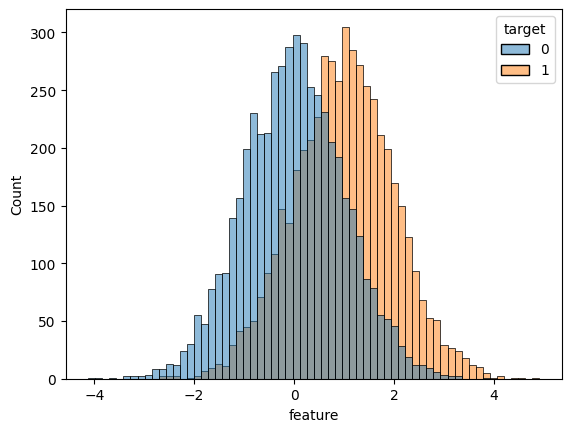

In [17]:
sns.histplot(df, x = 'feature', hue = 'target')

In [18]:
# запустите после того, как реализуете все функции 
woe_line(values=x, target=y, n_buckets=5)

### Эксперименты

#### №1

Как будут меняться график, метрики разделяющей способности и $R^2$ при изменении дисперсии шума (параметр `noise_std`)?

In [19]:
noise_std = 4
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
woe_line(values=x, target=y, n_buckets=5)

In [20]:
noise_std = 2
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
woe_line(values=x, target=y, n_buckets=5)

In [21]:
noise_std = 1
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
woe_line(values=x, target=y, n_buckets=5)

In [22]:
noise_std = 0.5
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
woe_line(values=x, target=y, n_buckets=5)

In [23]:
noise_std = 0.25
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
woe_line(values=x, target=y, n_buckets=5)

In [24]:
noise_std = 0.125
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
woe_line(values=x, target=y, n_buckets=5)

<Axes: xlabel='feature', ylabel='Count'>

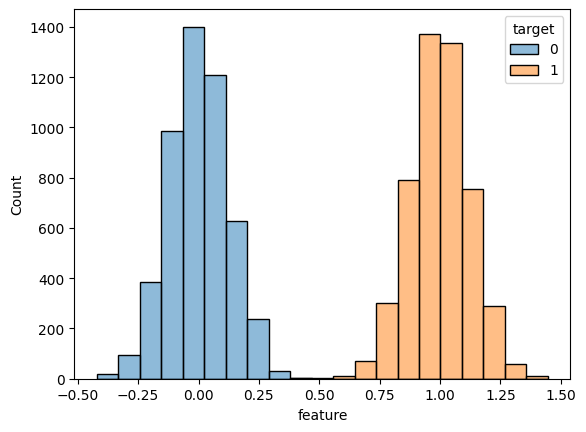

In [25]:
df["feature"] = x
sns.histplot(df, x = 'feature', hue = 'target')

При ↓noise_std: AUC↑ и IV↑  
Увеличение noise_std незначительно увеличило линейность графика

#### №2

Запустите функцию с `values=x ** 2`. Как по графику определить эту ситуацию? Что нужно делать в таком случае?

In [26]:
noise_std = 1.
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
woe_line(values=(x**2), target=y, n_buckets=10)

In [27]:
woe_line(values=np.sqrt(x**2), target=y, n_buckets=10)

- С увеличением WoE значительно увеличивается расстояние(значение переменной) между точками  
- Переменная больше или равна нулю  

Можно взять корень из квадрата, однако, тк квадрат не имеет обратной функции, появится небольшой шум (точки слева будут находиться в одном бакете с точками справа)

#### №3

Запустите функцию с `values=np.exp(x)`. Как по графику определить эту ситуацию? Что нужно делать в таком случае?

In [28]:
woe_line(values=np.exp(x), target=y, n_buckets=10)

In [29]:
woe_line(values=np.log(np.exp(x)), target=y, n_buckets=10)

- Также с увеличением WoE значительно увеличивается расстояние(значение переменной) между точками, однако скорость возрастания выше  
- Переменная больше или равна нулю  

В данном случае можно просто взять логарифм

## Часть 2. Строим ЛогРег.

В этом пунтке попробуем применить все наши навыки 

Скачайте датасет по [ссылке](https://data.tinkoff.ru/s/Nca7PoTNYokXgNF). Пароль вы найдете в телеграм-канале курса, в посте с анонсом домашки.

In [30]:
df = pd.read_csv('risks-24-hw1.csv', index_col=0)
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,d4p12
0,-1.444709,3.554779,1.308371,-0.689329,0.366748,2.646755,1,8.825418,2.646755,11.565953,-513.014565,-1.072893,7.936545,0.047069,B,1
1,1.132531,-0.207661,-2.142882,0.000527,2.369319,8.712916,1,3.453220,8.712916,4.935665,-39.351891,3.409855,17.015210,0.029288,A,0
2,1.268781,-0.243999,10000.000000,0.000683,0.100580,2.137392,1,-10.116061,2.137392,6.234414,-4.993050,3.121126,4.878602,0.237255,A,0
3,-1.278475,-2.579890,5.050763,-0.371907,0.523984,2.612065,1,6.780814,2.612065,2.682539,-509.273095,-1.242741,20.293025,0.907788,B,0
4,3.507807,0.152661,-8.905005,0.939313,1.092974,4.224315,1,-10.638134,4.224315,6.881602,-2.034797,2.814972,7.352399,0.276854,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-3.061422,-0.163832,4.812768,-0.417794,0.182394,-0.582374,0,-9.959913,-0.582374,5.294558,-524.265291,-1.648415,5.410059,0.855190,B,0
99996,0.222451,-0.273191,0.380895,0.002889,3.724334,1.007479,1,-1.645952,1.007479,5.571499,-13.499956,3.386865,92.903615,0.006668,A,1
99997,1.078498,0.339526,-5.184847,0.234131,0.544720,-3.320917,1,-5.565932,-3.320917,-0.433263,3.928387,3.290285,1.233853,0.160933,A,1
99998,-1.431421,-0.605388,2.466023,-0.009963,0.308079,6.889658,0,-4.517188,6.889658,10.812813,-507.593408,-1.398568,1904.246147,0.077164,B,1


Как вы выдите, ```feature_1, ..., feature_14``` - числа 
```feature_15``` - категориальная фича

### Задание 0. EDA.

Как бы вы начали знакомиться с данными до построения модели? Постройте 3-5 графиков / таблиц, чтобы передать основную информацию о датасете.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   feature_1   100000 non-null  float64
 1   feature_2   100000 non-null  float64
 2   feature_3   100000 non-null  float64
 3   feature_4   100000 non-null  float64
 4   feature_5   100000 non-null  float64
 5   feature_6   100000 non-null  float64
 6   feature_7   100000 non-null  int64  
 7   feature_8   100000 non-null  float64
 8   feature_9   100000 non-null  float64
 9   feature_10  100000 non-null  float64
 10  feature_11  100000 non-null  float64
 11  feature_12  100000 non-null  float64
 12  feature_13  100000 non-null  float64
 13  feature_14  100000 non-null  float64
 14  feature_15  100000 non-null  object 
 15  d4p12       100000 non-null  int64  
dtypes: float64(13), int64(2), object(1)
memory usage: 13.0+ MB


In [32]:
df.corr(numeric_only=True).style.background_gradient(cmap='coolwarm')

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,d4p12
feature_1,1.000000,0.001111,0.131917,0.393659,0.003867,0.001231,0.005264,0.003225,0.001231,0.005444,0.604099,0.618449,-0.132481,-0.003012,0.077038
feature_2,0.001111,1.000000,0.002313,-0.000251,0.004041,0.001868,-0.000656,-0.010136,0.001868,0.002549,0.003208,0.003786,-0.000730,0.002958,0.000207
feature_3,0.131917,0.002313,1.000000,0.145927,-0.000165,0.003059,-0.000333,-0.002135,0.003059,0.002412,0.226866,0.232077,-0.047751,-0.002425,0.058054
feature_4,0.393659,-0.000251,0.145927,1.000000,0.002450,-0.001427,0.001629,-0.001789,-0.001427,0.004015,0.612868,0.627982,-0.133029,-0.003995,0.100041
feature_5,0.003867,0.004041,-0.000165,0.002450,1.000000,-0.006599,0.002620,0.002643,-0.006599,0.000186,0.003872,0.003790,-0.004816,-0.000549,0.000466
feature_6,0.001231,0.001868,0.003059,-0.001427,-0.006599,1.000000,-0.000486,-0.005058,1.000000,-0.003310,0.000944,0.001009,0.000115,0.000603,-0.002189
feature_7,0.005264,-0.000656,-0.000333,0.001629,0.002620,-0.000486,1.000000,-0.006107,-0.000486,-0.000442,0.004439,0.005706,0.001697,-0.000900,0.005162
feature_8,0.003225,-0.010136,-0.002135,-0.001789,0.002643,-0.005058,-0.006107,1.000000,-0.005058,0.007169,0.002347,0.002465,0.000146,-0.009977,0.012618
feature_9,0.001231,0.001868,0.003059,-0.001427,-0.006599,1.000000,-0.000486,-0.005058,1.000000,-0.003310,0.000944,0.001009,0.000115,0.000603,-0.002189
feature_10,0.005444,0.002549,0.002412,0.004015,0.000186,-0.003310,-0.000442,0.007169,-0.003310,1.000000,0.007201,0.006809,-0.005512,-0.001455,0.006396


In [33]:
df.loc[:, df.columns != 'feature_15'].agg(['min','mean', 'median', 'max', 'std'])

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,d4p12
min,-54.598150,-38296.171946,-10000.000000,-1.999994e+00,0.000002,-16.569150,0.000000,-26.496544,-16.569150,-16.847030,-1012.820365,-9.210340,1.666947e-19,6.195140e-11,0.000000
mean,-0.004065,-0.198827,-6.283870,-1.250730e-01,1.003480,2.973727,0.901520,-2.514795,2.973727,3.640370,-256.924907,1.013153,9.969348e+02,2.885691e-01,0.425370
median,-0.058406,-0.072894,0.003200,-2.253828e-09,0.694669,2.971161,1.000000,-2.511154,2.971161,3.669848,-282.922772,-0.800022,2.341854e+01,4.439380e-02,0.000000
max,39.011329,20133.753873,10000.000000,9.999952e-01,12.006909,19.874766,1.000000,19.258719,19.874766,24.764462,446.685530,3.951220,3.729609e+05,1.000000e+00,1.000000
std,2.625003,169.576125,2344.152317,5.939374e-01,1.004035,3.998071,0.297964,5.009291,3.998071,4.977886,260.742462,2.314468,4.699415e+03,3.785086e-01,0.494401


<Axes: >

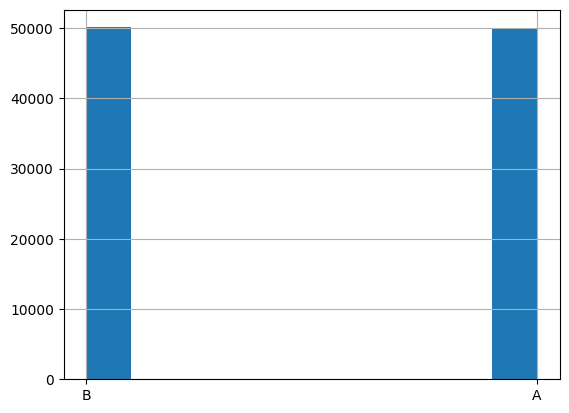

In [34]:
df["feature_15"].hist()

### Задание 1. Бейзлайн.

Попробуйте построить ЛогРег только на числовых данных. Для этого разбейте датасет на трейн и тест (80/20). Перед обучением логрега стандартизуйте переменные. Это может быть полезно для численной устойчивости алгоритмов оптимизации.

Для этой модели и всех дальнейших:

1. Получилась ли модель линейной? Постройте график линейности на трейне и на тесте и сделайте вывод.
2. Расчитайте AUC и IV на трейне и на тесте. Что можно сказать о переобучении?

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [36]:
df_ex1 = df.loc[:, df.columns != 'feature_15']
X, y = df_ex1.loc[:, df_ex1.columns != 'd4p12'], df_ex1['d4p12']
scal = StandardScaler()
X = scal.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [37]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [38]:
probs_test = model.predict_proba(X_test)[:, 1]
woe_line(logit(probs_test), y_test, 10)

In [39]:
probs_train = model.predict_proba(X_train)[:, 1]
woe_line(logit(probs_train), y_train, 10)

- R2 > 0.95, что говорит о линейности модели, однако AUC и IV не такие высокие
- Модель не имеет признаков переобучения, так как показатели AUC и IV близки на трейне и тесте  
- Показатель IV не слишком высок, что говорит об небольшой объясняющей способности модели по отношению к вариативности данных

### Задание 2. Добавляем категориальную переменную.

Повторите задание 1, включив в модель категориальную переменную (например, с помощью one-hot encoding).

Улучшилось ли качество?

In [40]:
df_ex2 = pd.concat([df.iloc[:, df.columns != 'feature_15'], pd.get_dummies(df['feature_15'])], axis=1)
X, y = df_ex2.loc[:, df_ex2.columns != 'd4p12'], df_ex2['d4p12']
scal = StandardScaler()
X = scal.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [41]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [42]:
probs_test = model.predict_proba(X_test)[:, 1]
woe_line(logit(probs_test), y_test, 10)

In [43]:
probs_train = model.predict_proba(X_train)[:, 1]
woe_line(logit(probs_train), y_train, 10)

- AUC вырос, что говорит об лучшей предсказательной способности модели по сравнению с предыдущими
- IV заметно вырос, модель начала давать более информативные результаты
- R2 не изменился, модель также линейна
- Доверительные интервалы увеличились

### Задание 3. Линеаризация переменных.

На самом деле, категориальные переменные можно учитывать в моделях совсем по-другому. С их помощью можно выделить в модели сегменты. Каждому сегменту соответствует своя модель (в нашем случае логрег). 

Примером такой сегментации может стать сегментация по наличию кредитной истории. В этом случае на разных сегментах будут не просто отдельные модели, но и даже разный изначальный набор признаков. Другое свидетельство удачной сегментации – разный характер зависимости признаков и целевой переменной. Это можно увидеть на графике линейности признака по WoE. Этим мы и займемся далее.

Используйте переменную 15 для сегментации модели. На каждом из двух сегментов линеаризуйте переменные. Для этого приложите:
 - график линейности переменной до преобразования
 - график после подобранного преобразования

Помимо этого:
 - попробуйте линеаризовать какие-нибудь 2 переменные *на всей выборке*. Получилось ли у вас что-то? Постройте график.
 - по графику линейности определите шумовые (либо слабоинформативные) переменные. В конце задания приложите их список.

In [44]:
df1 = df[df["feature_15"] == 'A'].drop("feature_15", axis=1)
df2 = df[df["feature_15"] == 'B'].drop("feature_15", axis=1)

In [45]:
X, y = df1.loc[:, df1.columns != 'd4p12'], df1['d4p12']

In [46]:
feature00 = X.iloc[:, 0].to_numpy()
woe_line(feature00, y, 20)

In [47]:
feature00 = -np.log(X.iloc[:, 0].to_numpy())
woe_line(feature00, y, 20)

In [48]:
feature10 = X.iloc[:, 1].to_numpy()
woe_line(feature10, y, 20)

In [49]:
feature10 = -1/X.iloc[:, 1].to_numpy()
woe_line(feature10, y, 20)

In [50]:
feature20 = X.iloc[:, 2].to_numpy()
woe_line(feature20, y, 20)

In [51]:
feature20 = X.iloc[:, 2].to_numpy().clip(max=7)
woe_line(feature20, y, 20)

In [52]:
feature30 = X.iloc[:, 3].to_numpy()
woe_line(feature30, y, 20)

In [53]:
feature40 = X.iloc[:, 4].to_numpy()
woe_line(feature40, y, 20)

In [54]:
feature50 = X.iloc[:, 5].to_numpy()
woe_line(feature50, y, 20)

In [55]:
feature60 = X.iloc[:, 6].to_numpy()
woe_line(feature60, y, 2)

In [56]:
feature70 = X.iloc[:, 7].to_numpy()
woe_line(feature70, y, 20)

In [57]:
feature80 = X.iloc[:, 8].to_numpy()
woe_line(feature80, y, 20)

In [58]:
feature90 = X.iloc[:, 9].to_numpy()
woe_line(feature90, y, 20)

In [59]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [60]:
def cube_sqrt(arr):
    return np.copysign(np.abs(arr) ** (1/3), arr)

In [61]:
feature100 = X.iloc[:, 10].to_numpy()
woe_line(feature100, y, 10)

In [62]:
feature100 = X.iloc[:, 10].to_numpy()
woe_line(cube_sqrt(feature100), y, 10)

In [63]:
feature110 = X.iloc[:, 11].to_numpy()
woe_line(feature110, y, 11)

In [64]:
feature120 = X.iloc[:, 12].to_numpy()
woe_line(feature120, y, 10)

In [65]:
feature130 = X.iloc[:, 13].to_numpy()
woe_line(feature130, y, 10)

In [66]:
feature13 = -logit(X.iloc[:, 13].to_numpy())
woe_line(feature13, y, 10)

In [67]:
X, y = df2.loc[:, df2.columns != 'd4p12'], df2['d4p12']

In [68]:
feature01 = X.iloc[:, 0].to_numpy()
woe_line(feature01, y, 10)

In [69]:
feature01 = -np.log(np.abs(X.iloc[:, 0].to_numpy()))
woe_line(feature01, y, 10)

In [70]:
feature11 = X.iloc[:, 1].to_numpy()
woe_line(feature11, y, 10)

In [71]:
feature11 = 1/X.iloc[:, 1].to_numpy()
woe_line(feature11, y, 10)

In [72]:
feature21 = X.iloc[:, 2].to_numpy()
woe_line(feature21, y, 10)

In [73]:
feature21 = -(X.iloc[:, 2].to_numpy()).clip(-7)
woe_line(feature21, y, 10)

In [74]:
feature31 = X.iloc[:, 3].to_numpy()
woe_line(feature31, y, 10)

In [75]:
feature41 = X.iloc[:, 4].to_numpy()
woe_line(feature41, y, 10)

In [76]:
feature51 = X.iloc[:, 5].to_numpy()
woe_line(feature51, y, 10)

In [77]:
feature61 = X.iloc[:, 6].to_numpy()
woe_line(feature61, y, 2)

In [78]:
feature71 = X.iloc[:, 7].to_numpy()
woe_line(feature71, y, 10)

In [79]:
feature81 = X.iloc[:, 8].to_numpy()
woe_line(feature81, y, 10)

In [80]:
feature91 = X.iloc[:, 9].to_numpy()
woe_line(feature91, y, 10)

In [81]:
feature101 = X.iloc[:, 10].to_numpy()
woe_line(feature101, y, 10)

In [82]:
feature101 = cube_sqrt(X.iloc[:, 10].to_numpy() + 513)
woe_line(feature101, y, 10)

In [83]:
feature111 = X.iloc[:, 11].to_numpy()
woe_line(feature111, y, 10)

In [84]:
feature121 = X.iloc[:, 12].to_numpy()
woe_line(feature121, y, 10)

In [85]:
feature131 = X.iloc[:, 13].to_numpy()
woe_line(feature131, y, 10)

In [86]:
feature131 = -logit(X.iloc[:, 13].to_numpy())
woe_line(feature131, y, 10)

Подытожим, переменные которые линеризируются в сегменте 'feature_15' == 'A':
```
1) -np.log(np.abs(X.iloc[:, 0].to_numpy()))
2) -1/X.iloc[:, 1].to_numpy()
3) X.iloc[:, 2].to_numpy().clip(max=7)
4) cube_sqrt(X.iloc[:, 10].to_numpy())
5) X.iloc[:, 11].to_numpy()
6) -logit(X.iloc[:, 13].to_numpy())
```

Переменные которые линеризируются в сегменте 'feature_15' == 'B':
```
1) -np.log(np.abs(X.iloc[:, 0].to_numpy()))
2) 1/X.iloc[:, 1].to_numpy()
3) -(X.iloc[:, 2].to_numpy()).clip(-7)
4) cube_sqrt(X.iloc[:, 10].to_numpy() + 513)
5) X.iloc[:, 11].to_numpy()
6) -logit(X.iloc[:, 13].to_numpy())
```

Рассмотрим feature_1 и feature_14 на всей выборке и линеаризуем их

In [96]:
woe_line(df['feature_1'].to_numpy(), df['d4p12'], 10)

In [97]:
woe_line(-np.log(np.abs(df['feature_1'].to_numpy())), df['d4p12'], 10)

In [102]:
woe_line(df['feature_14'].to_numpy(), df['d4p12'], 10)

In [101]:
woe_line(-logit(df['feature_14'].to_numpy()), df['d4p12'], 10)

Шумовые (либо слабоинформативные) переменные на сегменте 'A':  

- feature_4, ..., feature_10, feature_13

Шумовые (либо слабоинформативные) переменные на сегменте 'B':  

- feature_4, ..., feature_10, feature_13

```
Также, в feature_3 есть шум, который убирается с помощью clip без потери предсказательной способности модели  
```

На обеих сегментах одни и теже шумовые (либо слабоинформативные) переменные.
Поэтому можно рассматривать модели на:  
```
- feature_1, feature_2, feature_3, feature_11, feature_12, feature_14
```

In [223]:
good_feature = ['feature_1', 'feature_2', 'feature_3', 'feature_11', 'feature_12', 'feature_14']

In [224]:
X1, y1 = df1.loc[:, good_feature], df1['d4p12']
X2, y2 = df2.loc[:, good_feature], df2['d4p12']

In [225]:
X1['feature_1'] = -np.log(np.abs(X1['feature_1'].to_numpy()))
X2['feature_1'] = -np.log(np.abs(X2['feature_1'].to_numpy()))
X1['feature_2'] = -1/X1['feature_2'].to_numpy()
X2['feature_2'] = 1/X2['feature_2'].to_numpy()
X1['feature_3'] = X1['feature_3'].to_numpy().clip(max=7)
X2['feature_3'] = -X2['feature_3'].to_numpy().clip(-7)
X1['feature_11'] = cube_sqrt(X1['feature_11'].to_numpy())
X2['feature_11'] = cube_sqrt(X2['feature_11'].to_numpy() + 513)
X1['feature_12'] = X1['feature_12'].to_numpy()
X2['feature_12'] = X2['feature_12'].to_numpy()
X1['feature_14'] = -logit(X1['feature_14'].to_numpy())
X2['feature_14'] = -logit(X2['feature_14'].to_numpy())

In [226]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, shuffle=False)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, shuffle=False)

In [227]:
model1 = LogisticRegression()
model2 = LogisticRegression()
model1.fit(X_train1, y_train1)
model2.fit(X_train2, y_train2)

LogisticRegression()

### Задание 4. Финальная модель.

Обучите модели на признаках, которые вы отобрали и линеаризовали в задании 3. Пусть $logit_A$ – модель, обученная на сегменте $feature_{15} = A$. $logit_B$ – модель на втором сегменте. Тогда модель на всей выборке будем считать по формуле

$$
logit(x) = \mathbb I \{ feature_{15} = A \} \times logit_A(x) + \mathbb I \{ feature_{15} = B \} \times logit_B(x)
$$


Посчитайте для этой модели AUC и IV, оцените линейность на трейне и тесте. Сравните результаты с бейзлайном из задания 1.

Подсказка: если вы все сделали правильно, можно ожидать ROC AUC около 0.9 на тестовой выборке.

In [228]:
probs1 = model1.predict_proba(X_test1)[:, 1]
woe_line(logit(probs1), y_test1, 10)

In [229]:
probs2 = model2.predict_proba(X_test2)[:, 1]
woe_line(logit(probs2), y_test2, 10)

In [230]:
probs_concat = np.concatenate([probs1, probs2])
y_test_concat = pd.concat([y_test1, y_test2], axis=0)

In [231]:
woe_line(logit(probs_concat), y_test_concat, 10)

По сравнению с бейзлайном задания 1, модель немного выпрямилась по центру(стала более линейной), IV модели значительно выросла, что говорит о ее более высокой разделяющей способностью, по сравнению с бейзлайном задания 1. Также AUC увеличился на 0.2, что очень хороший результат!

# Часть 3. Бонус.

На лекции мы накопили ряд упражнений, которые стоит решить для понимания происходившего. Вы можете $\TeX$ать их прямо в ноуте (или прикреплять картинки, если так удобнее).

#### **Упражнение 1**

Для определения $WoE$ мы пользовались Теоремой Байеса. Примените ее и **покажите, что верно равенство**:

$$
\ln \left(  \frac{P(x_i|y=1)}{P(x_i|y=0)} \right) = ... = \ln \left( \frac{P(y=1|x_i)}{P(y=0|x_i)} \right) - \ln \left( \frac{P(y=1)}{P(y=0)} \right)
$$

$$
\ln \left(  \frac{P(x_i|y=1)}{P(x_i|y=0)} \right) = \ln \left(  \frac{P(y=1|x_i)P(y=0)}{P(y=0|x_i)P(y=1)} \right) = \ln \left( \frac{P(y=1|x_i)}{P(y=0|x_i)} \right) + \ln \left( \frac{P(y=0)}{P(y=1)} \right) = \ln \left( \frac{P(y=1|x_i)}{P(y=0|x_i)} \right) - \ln \left( \frac{P(y=1)}{P(y=0)} \right)\blacksquare
$$

#### **Упражнение 2**

Известно:

$WoE$ можно посчитать так:
$WoE_i(x_i) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big ) $

Частота выхода в дефолт:  $badrate = \frac{B}{B+G}; \quad badrate_i = \frac{B_i}{B_i+G_i}$

$
\sigma (x) = \frac{1}{1+e^{-x}}; \quad logit(x) = \ln \left( \frac{x}{1-x} \right)
$

**Покажите, что**
$WoE_i(x_i) = logit(badrate_i) - logit(badrate)$

Пойдем от обратного: допустим это так. Тогда:
$$
WoE_i(x_i) = logit(badrate_i) - logit(badrate) = \ln \left( \frac{badrate_i}{1-badrate_i} \right) - \ln \left( \frac{badrate}{1-badrate} \right) =
$$
$$
= \ln \left( \frac{\frac{B_i}{B_i+G_i}}{1-\frac{B_i}{B_i+G_i}} \right) - \ln \left( \frac{\frac{B}{B+G}}{1-\frac{B}{B+G}} \right) = \ln \left( \frac{B_i}{G_i} \right) - \ln \left(\frac{B}{G} \right)
\blacksquare
$$

#### **Упражнение 3**

Пусть даны два дискретных распределения: 

$B=(b_1, ..., b_n)$ и $G=(g_1, ..., g_n)$.

KL-дивергенция для дискретных распределений

$$D_{KL}(B||G) = \sum_{j=1}^{n} b_j \ln \left( \frac{b_j}{g_j} \right)$$


Пусть $x$ - дикретный признак, принмиающий значения $x_1,...,x_n$.
Известно определение IV через KL-дивергенцию:

$$
IV_x = D_{KL}(B_x||G_x)+D_{KL}(G_x||B_x)
$$
где 

$$
B_x (x_i) = P(x=x_i|y=1) = b_i; \quad G_x (x_i) = P(x=x_i|y=0) = g_i
$$

**Выразите $IV$ через $WoE$**

$$
\text{IV} = \sum_{i = 1}^{n}\Big ( \frac{B_i}{B} - \frac{G_i}{G} \Big ) \times \text{WoE}_i
$$




$$
IV = D_{KL}(B||G)+D_{KL}(G||B) = \sum_{j=1}^{n} b_j \ln \left( \frac{b_j}{g_j} \right) + \sum_{j=1}^{n} g_j \ln \left( \frac{g_j}{b_j} \right) = \sum_{j=1}^{n} (b_j - g_j) \ln \left( \frac{b_j}{g_j} \right) = \sum_{i = 1}^{n}\Big ( \frac{B_i}{B} - \frac{G_i}{G} \Big ) \times \text{WoE}_i
$$